# Project Initialization


## Load Packages


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

##  Initializing a Connection to Spark

In [ ]:
%%capture
!apt install libkrb5-dev
!wget https://downloads.apache.org/spark/spark-3.0.1/spark-3.0.1-bin-hadoop3.2.tgz
!tar xf spark-3.0.1-bin-hadoop3.2.tgz
!pip install findspark
!pip install sparkmagic
!pip install pyspark
! pip install pyspark --user
! pip install seaborn --user
! pip install plotly --user
! pip install imageio --user
! pip install folium --user

In [ ]:
%%capture
!apt update
!apt install gcc python-dev libkrb5-dev

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.types import *
import pyspark.sql.functions as F

import os

spark = SparkSession.builder.appName('545Project').getOrCreate()

## Download data from google drive

Connect google drive.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data wrangling, cleaning and shaping

## Load Dataset

In this section, we will handle the data of animates, `AnimeList.csv` contains large data about different animes, such as `title`, `airing`, `studio` and `licensor`.

We'll use Spark to look into anime data from google drive. To start, let's read our data into Spark. 

For UserAnime data, we just use pandas to load. Here we use `quote` and `escape` to avoid the bad effect of double quote.

In [ ]:
anime_sdf = spark.read.load('/content/drive/Shareddrives/545 Project/AnimeList.csv', format = "csv",header="true",quote="\"", escape = "\"")


In [ ]:
anime_sdf.createOrReplaceTempView('anime')

Take a look at the data.



In [ ]:
anime_sdf.show()

+--------+--------------------+--------------------+-------------------------+--------------------+--------------------+----+-----------+--------+---------------+------+--------------------+--------------------+---------------+--------------------+-----+---------+----+----------+-------+---------+--------------------+-----------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------------------+--------------------------+
|anime_id|               title|       title_english|           title_japanese|      title_synonyms|           image_url|type|     source|episodes|         status|airing|        aired_string|               aired|       duration|              rating|score|scored_by|rank|popularity|members|favorites|          background|  premiered|           broadcast|             related|            producer|            licensor|              studio|               genre|         opening_theme|            

## Drop unrelated columns



Like a TV series, there are some unrealted columns that we do not need in our project. 

Here we first drop `title_english`, `title_syynonyms`, `image_url`, `background` , `primeried`, `related`, `opening_theme` and `ending_theme`. These are totally description columns and is useless in our analyzation.


In [ ]:
anime_sdf.createOrReplaceTempView('anime')

query = '''
        SELECT anime_id, title, title_japanese, type, source, episodes,
        status, airing, aired_string, aired, duration, rating, score,
        scored_by, rank, popularity, members, favorites, broadcast,
        producer, licensor, studio, genre 
        From anime
        '''

anime_cleaned_sdf = spark.sql(query)

Then we can notice that `status` and `airing` contains same information, `aired_string` and `aired` contains sanme information.

Also, we won't investigate animates that even has no english name.

Here we just need animates that are aired, use `WHERE` to query.

In [ ]:
anime_cleaned_sdf.createOrReplaceTempView('anime_cleaned')

query = '''
        SELECT anime_id, title, title_japanese, type, source, episodes,
        aired_string, duration, rating, score,
        scored_by, rank, popularity, members, favorites, 
        broadcast, producer, licensor, studio, genre 
        From anime_cleaned 
        WHERE airing = False AND title <> 'None'
        '''

anime_cleaned_sdf = spark.sql(query)

Calculate the difference after choosing aired animates, check if it is too large.

In [ ]:
difference = anime_sdf.count() - anime_cleaned_sdf.count()
difference

351

There are not much useful information in `broadcast`, `licensor`, `producer` so we drop the 3 columns.

`studio` also have None but the number is acceptable,so we have to drop none here.

In [ ]:
anime_cleaned_sdf.createOrReplaceTempView('anime_cleaned')

query = '''
        SELECT anime_id, title, title_japanese, type, source, episodes,
        aired_string, duration, rating, score,scored_by, rank,
         popularity, members, favorites, studio, genre 
        From anime_cleaned 
        WHERE studio <> 'None'
        '''

anime_cleaned_nonull_sdf = spark.sql(query)

In [ ]:
anime_cleaned_nonull_sdf.show()

+--------+--------------------+-------------------------+----+-----------+--------+--------------------+---------------+--------------------+-----+---------+----+----------+-------+---------+--------------------+--------------------+
|anime_id|               title|           title_japanese|type|     source|episodes|        aired_string|       duration|              rating|score|scored_by|rank|popularity|members|favorites|              studio|               genre|
+--------+--------------------+-------------------------+----+-----------+--------+--------------------+---------------+--------------------+-----+---------+----+----------+-------+---------+--------------------+--------------------+
|   11013|       Inu x Boku SS|                妖狐×僕SS|  TV|      Manga|      12|Jan 13, 2012 to M...|24 min. per ep.|PG-13 - Teens 13 ...| 7.63|   139250|1274|       231| 283882|     2809|    David Production|Comedy, Supernatu...|
|    2104|    Seto no Hanayome|               瀬戸の花嫁|  TV|      Mang

## Time Convert and Format

There are several columns contains time data, we need to use `TO_DATE` to convert them. This step works on `aired_string` and `duration`.

Since plenty of animates has no end date, so we only take start date here.
 Remember to convert them to datetime.

In [ ]:
# we process this explode in pandas
anime_cleaned = anime_cleaned_nonull_sdf.toPandas()

# first use apply to extract start_date and end_date string
anime_cleaned['start_time'] = anime_cleaned['aired_string'].apply(lambda x: x.split("to")[0])


# drop time values that are Not available
anime_cleaned = anime_cleaned[anime_cleaned['start_time'] != 'Not available']

# use to_date to convert string to timestamp
anime_cleaned['start_time'] = anime_cleaned['start_time'].apply(lambda x: pd.to_datetime(x))

# convert the exact start time to start year
anime_cleaned['start_year'] = anime_cleaned['start_time'].apply(lambda x: x.year)

In [ ]:
# extract the duration time from duration
anime_cleaned['duration'] = anime_cleaned['duration'].apply(lambda x: x.split("min")[0])
# drop duration values that are Unknown
anime_cleaned = anime_cleaned[anime_cleaned['duration'] != 'Unknown']

Define a function to convert the duration column into min-based integer.

Animates with duration smaller than 1 minute are considered as 1 minute.

In [ ]:
def convert_to_minutes(s):
  temp = s.split("min")[0]
  if "sec" in temp:
    return 1
  elif "hr" in temp:
    hr = (int) (temp.split("hr.")[0])
    try:
      min = (int) (temp.split("hr.")[1])
    except:
      min = 0
    return hr * 60 + min
  else:
    return (int) (temp)

In [ ]:
# create duration_minute to store the numeric value of duration
anime_cleaned['duration_min'] = anime_cleaned['duration'].apply(lambda x: convert_to_minutes(x))

# drop the original duration column and the original aired_string column
anime_cleaned = anime_cleaned.drop(columns = ['duration','aired_string','start_time'])

Convert `anime_id`, `episodes`, `score`, `scored_by`, `rank`, `popularity`, `members`, `favorites`, `start_year` to numeric type.


In [ ]:
anime_cleaned[['anime_id', 'episodes', 'score', 'scored_by', 'rank', 'popularity', 'members', 'favorites','start_year']] = \
 anime_cleaned[['anime_id', 'episodes', 'score', 'scored_by', 'rank', 'popularity', 'members', 'favorites','start_year']].apply(pd.to_numeric)

anime_cleaned = anime_cleaned.dropna()

Now we got the cleaning version of `anime` and `user_anime` as `anime_cleaned` and `user_anime_cleaned`, take a lot at them.

In [ ]:
anime_cleaned.reset_index(drop=True, inplace=True)
anime_cleaned

,anime_id,title,title_japanese,type,source,episodes,rating,score,scored_by,rank,popularity,members,favorites,studio,genre,start_year,duration_min
0,11013,Inu x Boku SS,妖狐×僕SS,TV,Manga,12,PG-13 - Teens 13 or older,7.63,139250,1274.0,231,283882,2809,David Production,"Comedy, Supernatural, Romance, Shounen",2012,24
1,2104,Seto no Hanayome,瀬戸の花嫁,TV,Manga,26,PG-13 - Teens 13 or older,7.89,91206,727.0,366,204003,2579,Gonzo,"Comedy, Parody, Romance, School, Shounen",2007,24
2,5262,Shugo Chara!! Doki,しゅごキャラ！！どきっ,TV,Manga,51,PG - Children,7.55,37129,1508.0,1173,70127,802,Satelight,"Comedy, Magic, School, Shoujo",2008,24
3,721,Princess Tutu,プリンセスチュチュ,TV,Original,38,PG-13 - Teens 13 or older,8.21,36501,307.0,916,93312,3344,Hal Film Maker,"Comedy, Drama, Magic, Romance, Fantasy",2002,16
4,12365,Bakuman. 3rd Season,バクマン。,TV,Manga,25,PG-13 - Teens 13 or older,8.67,107767,50.0,426,182765,2082,J.C.Staff,"Comedy, Drama, Romance, Shounen",2012,24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7775,30931,Usagi to Kame no Koutsuu Anzen,うさぎと亀の交通安全,OVA,Unknown,1,G - All Ages,4.00,5,12646.0,13794,67,0,Toei Animation,"Drama, Fantasy, Kids",2008,13
7776,30928,Tobidashi wa Abunaizo! Mushi Mushi Mura no Kou...,とびだしはあぶないぞ！ むしむし村の交通安全,OVA,Unknown,1,G - All Ages,3.57,7,12496.0,13753,69,0,Toei Animation,"Drama, Kids",2012,12
7777,27853,Ichinen Ikkumi,1ねん1くみ,OVA,Unknown,1,G - All Ages,4.33,6,10596.0,13724,70,1,Toei Animation,"Kids, School",2002,51
7778,36315,Mushi Mushi Mura no Nakama-tachi: Minna Ii Tok...,むしむし村の仲間たち みんないいとこあるんだよ,OVA,Original,1,G - All Ages,7.00,4,11396.0,14191,40,0,Toei Animation,Kids,2017,13


# Data Visualization

## Distributions

Implement Seaborn.


First use `anime_cleaned` to show to distribution of animates' scores, number of people who scored, popularity and favorites.


Text(0.5, 1.0, 'Distrubution of favorites')

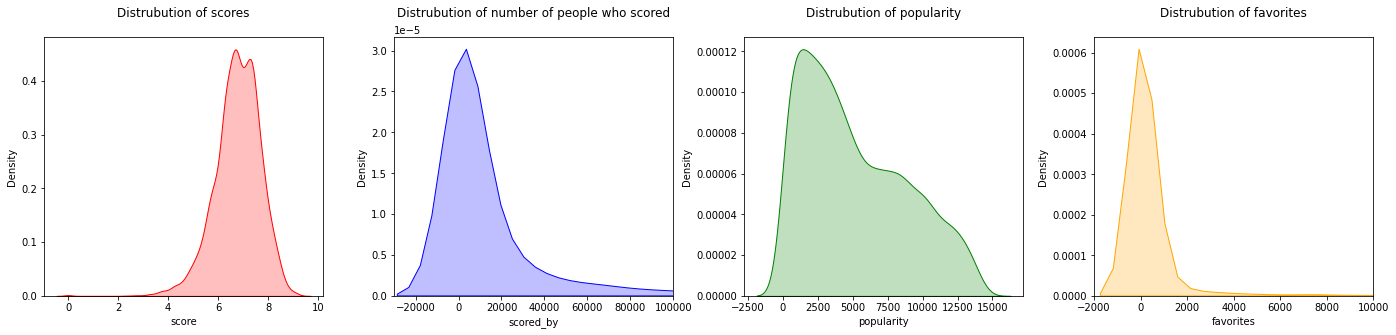

In [ ]:
# Use subplot to plot several distrubutions
fig, (ax_score, ax_scored_by, ax_popularity, ax_favorites) = plt.subplots(1, 4,figsize=(20,5))
fig.tight_layout(pad=4)

# distribution of score
ax_score = sns.kdeplot(anime_cleaned['score'],color='red',fill=True,legend=True, ax = ax_score)
ax_score.set_title('Distrubution of scores', pad = 20)

# distribution of number of people who scored
ax_scored_by = sns.kdeplot(anime_cleaned['scored_by'],color='blue',fill=True,legend=True, ax = ax_scored_by)
ax_scored_by.set_xlim(-30000,100000)
ax_scored_by.set_title('Distrubution of number of people who scored', pad = 20)


# distribution of popularity
ax_popularity = sns.kdeplot(anime_cleaned['popularity'],color='green',fill=True,legend=True, ax = ax_popularity)
ax_popularity.set_title('Distrubution of popularity', pad = 20)

# distribution of favorites 
ax_favorites = sns.kdeplot(anime_cleaned['favorites'],color='orange',fill=True,legend=True, ax = ax_favorites)
ax_favorites.set_xlim(-2000,10000)
ax_favorites.set_title('Distrubution of favorites', pad = 20)

## Best 500 animates on different criteria

Meanwhile, we can also use seaborn bubble plot to investigate the relation of `score`, `scored_by`, `popularity`, `favorites` with animates.

We take the frist 500 animes by rank, then use bubble plot to see how the 500 rank animes are distribute on 4 criterion.

Use `rank` as x, `start_year` as y, and the 4 criteria as y to draw bubble plot.

Text(0.5, 1.0, 'The 100 best animates defined on favorites')

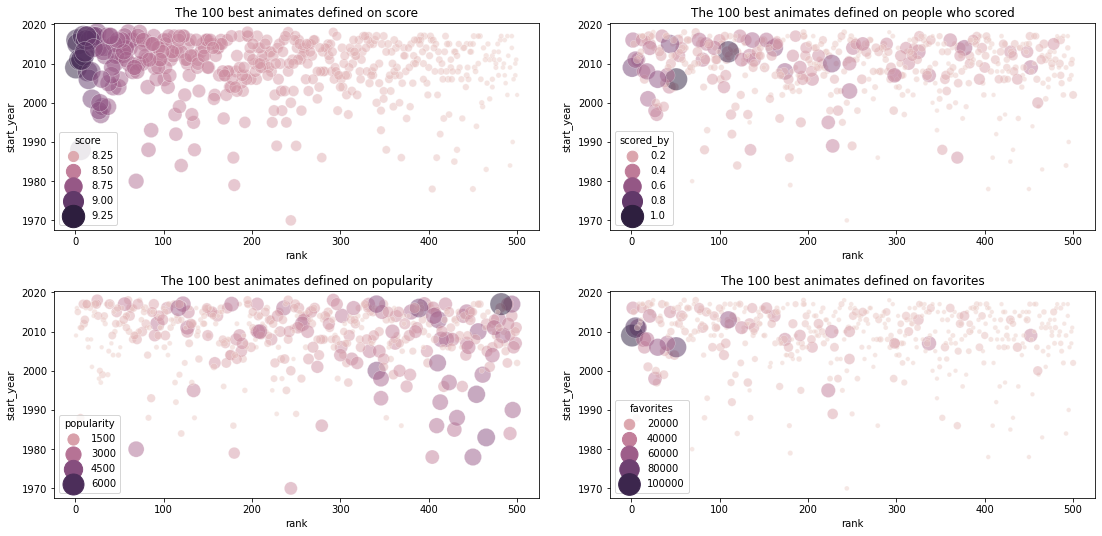

In [ ]:
fig, axes = plt.subplots(2, 2,figsize=(16,8))
fig.tight_layout(pad=4)

# get the temp df of the 100 best animates defined on score
animate_rank_score = anime_cleaned[anime_cleaned['rank'] <= 500]
axes[0,0] = sns.scatterplot(x="rank", y="start_year", size="score", sizes=(20,500), alpha=0.5, hue="score", data=animate_rank_score, ax = axes[0,0])
# add title for plot
axes[0,0].set_title("The 100 best animates defined on score")

# get the temp df of the 100 best animates defined on scored_by
axes[0,1] = sns.scatterplot(x="rank", y="start_year", size="scored_by", sizes=(20,500), alpha=0.5, hue="scored_by", data=animate_rank_score, ax = axes[0,1])
# add title for plot
axes[0,1].set_title("The 100 best animates defined on people who scored")


# get the temp df of the 100 best animates defined on popularity
axes[1,0] = sns.scatterplot(x="rank", y="start_year", size="popularity", sizes=(20,500), alpha=0.5, hue="popularity", data=animate_rank_score,ax = axes[1,0])
# add title for plot
axes[1,0].set_title("The 100 best animates defined on popularity")

# get the temp df of the 100 best animates defined on favorites
axes[1,1] = sns.scatterplot(x="rank", y="start_year", size="favorites", sizes=(20,500), alpha=0.5, hue="favorites", data=animate_rank_score, ax = axes[1,1])

# add title for plot
axes[1,1].set_title("The 100 best animates defined on favorites")


From the graph we can see the 500 rank animes have distinct dependency on different criteria. Almostly all top rank animates have higher scores and more favorites. 

However, on criteria of number of people who scored, the best animates does not have rank top among all animes. Even More, on the criteria of popularity, most popular animes often rank bottom among the 500 animes. 


## Most productive studio and year

Then we use barplot to draw the animates producted by each studio and the distribution of each year.|

Text(0.5, 1.0, 'The 20 most productive years')

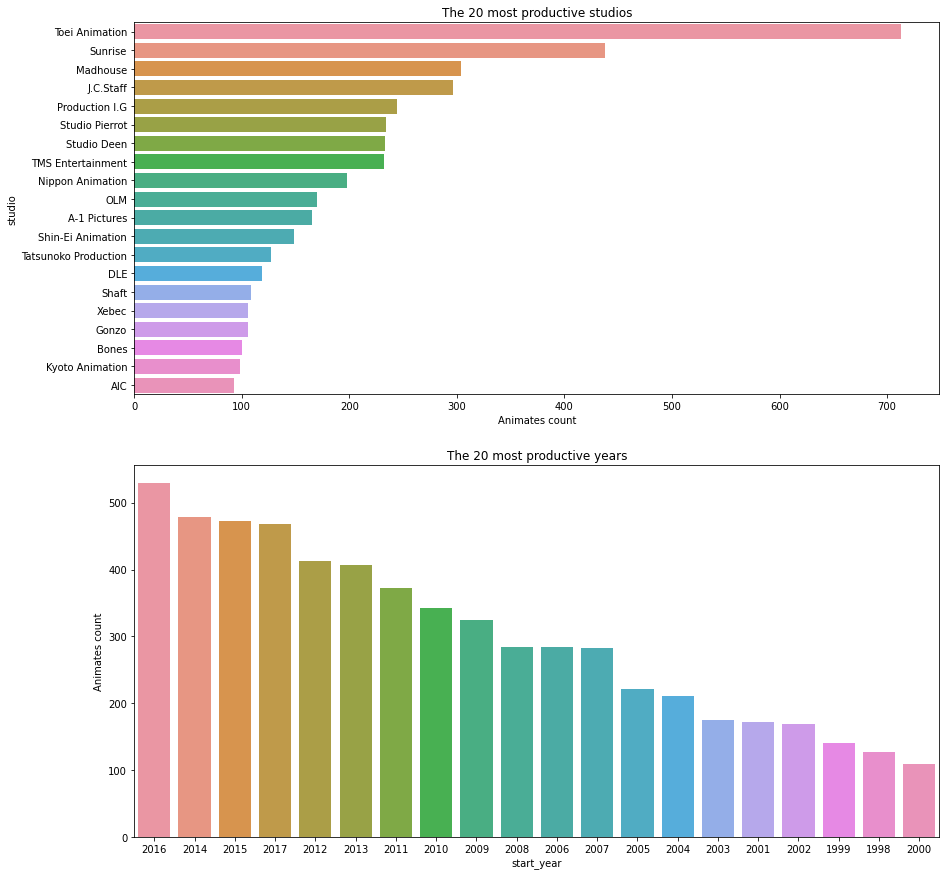

In [ ]:
fig, (ax_studio, ax_year) = plt.subplots(2, 1,figsize=(13,13))
fig.tight_layout(pad=5)

# get the temp df group by studio
animate_studio = anime_cleaned.groupby('studio').count()
animate_studio.reset_index(inplace=True)
# take the 20 most productive studio
animate_studio = animate_studio.sort_values(by = ['title'], ascending=False).iloc[:20,:]
ax_studio = sns.barplot(x='title',y='studio', data=animate_studio, ax = ax_studio)
ax_studio.set(xlabel= 'Animates count')
ax_studio.set_title('The 20 most productive studios')

# get the temp df group by year
animate_year = anime_cleaned.groupby('start_year').count()
animate_year.reset_index(inplace=True)
# take the 20 most productive studio
animate_year = animate_year.sort_values(by = ['title'], ascending=False).iloc[:20,:]
ax_year = sns.barplot(x='start_year',y='title', data=animate_year,order = animate_year['start_year'], ax = ax_year) 
ax_year.set(ylabel= 'Animates count')
ax_year.set_title('The 20 most productive years')

## Type and Source of Animates

We use pie plot to draw the type and source distribution of animates.



In [ ]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

In [ ]:
fig = make_subplots(rows=1, cols=1,specs=[[{'type': 'pie'}]],subplot_titles=['Type of Animates'])

animate_type =anime_cleaned.groupby('type').count().reset_index()

fig.add_trace(go.Pie(labels=animate_type['type'], 
            values=animate_type['title'],
            text=animate_type['type']), 
            row=1, col=1)

fig.update_layout(width=600, height=600)
fig.show()

In [ ]:
fig = make_subplots(rows=1, cols=1,specs=[[{'type': 'pie'}]],subplot_titles=['Source of Animates'])

animate_source =anime_cleaned.groupby('source').count().reset_index()

fig.add_trace(go.Pie(labels=animate_source['source'], 
            values=animate_source['title'],
            text=animate_source['source']),
              row=1, col=1)

fig.update_layout(width=800, height=800)
fig.show()

## Genre distribution and correlation

Since the genre columns is a list of genres, we need to explode it and extract the genre information and count them to draw distribution and the relation between multiple genres.

In [ ]:
genre_repeated = []
genre_list = []

anime_genre = anime_cleaned['genre']
# use double loop and split to add all genre (include repeatation) into list
for i in anime_genre.index:
  for j in anime_genre.get(i).split(", "):
      if j not in genre_repeated:
          genre_list.append(j)
      genre_repeated.append(j)

We use `genre_repeated` to count the appearence of each genre. And use `genre_list` to contain distinct genre information. 

Then we convert genre_repeated to series and count it.

In [ ]:
# convert list to series then dataframe
anime_genre_count = pd.Series(genre_repeated).value_counts() 
anime_genre_count_df = pd.DataFrame(anime_genre_count, columns = ['count'])
anime_genre_count_df.reset_index(inplace=True)

Text(0.5, 1.0, 'The most popular anime genres')

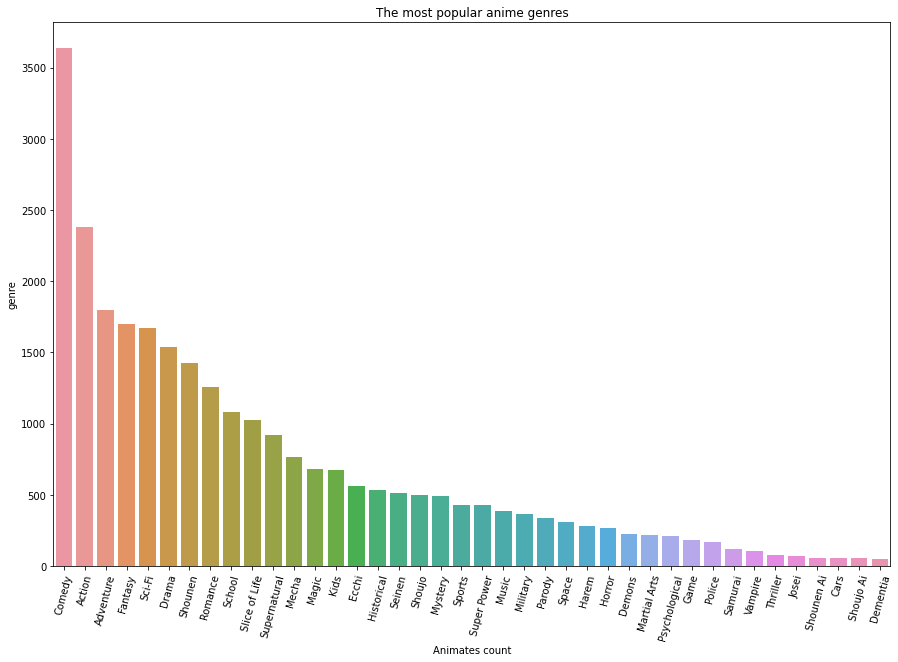

In [ ]:
# draw the distribution
plt.figure(figsize=(15,10))
ax_year = sns.barplot(x='index',y='count', data=anime_genre_count_df) 
ax_year.set(xlabel= 'Animates count')
ax_year.set(ylabel= 'genre')
plt.xticks(rotation= 75) 
ax_year.set_title('The most popular anime genres')

From the graph we can see that Comedy is the majority of anime genres, and it would be an imporant element in further learning.

# Stuido and genre Explode
Till now, we do data cleaning and data visualization based on distinct animes, but each animes may contain several genres and studios.

Since the frist genre is the most decesive genre, so for `genre` column we just leave the first element. However, several studios may make equal effort in producing an anime, so we need to explode `studio`, which may create duplicate anime entries in the dataframe, so we have to do it after data visualization.

In [ ]:
anime_cleaned['genre'] = anime_cleaned['genre'].apply(lambda x: x.split(",")[0])

In [ ]:
def convert_to_list(x):
  studios = []
  for i in x.split(","):
    studios.append(i)
  return studios

anime_cleaned['studio'] = anime_cleaned['studio'].apply(lambda x: convert_to_list(x))
anime_cleaned = anime_cleaned.explode('studio')


In [ ]:
anime_cleaned

,anime_id,title,title_japanese,type,source,episodes,rating,score,scored_by,rank,popularity,members,favorites,studio,genre,start_year,duration_min
0,11013,Inu x Boku SS,妖狐×僕SS,TV,Manga,12,PG-13 - Teens 13 or older,7.63,139250,1274.0,231,283882,2809,David Production,Comedy,2012,24
1,2104,Seto no Hanayome,瀬戸の花嫁,TV,Manga,26,PG-13 - Teens 13 or older,7.89,91206,727.0,366,204003,2579,Gonzo,Comedy,2007,24
2,5262,Shugo Chara!! Doki,しゅごキャラ！！どきっ,TV,Manga,51,PG - Children,7.55,37129,1508.0,1173,70127,802,Satelight,Comedy,2008,24
3,721,Princess Tutu,プリンセスチュチュ,TV,Original,38,PG-13 - Teens 13 or older,8.21,36501,307.0,916,93312,3344,Hal Film Maker,Comedy,2002,16
4,12365,Bakuman. 3rd Season,バクマン。,TV,Manga,25,PG-13 - Teens 13 or older,8.67,107767,50.0,426,182765,2082,J.C.Staff,Comedy,2012,24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7775,30931,Usagi to Kame no Koutsuu Anzen,うさぎと亀の交通安全,OVA,Unknown,1,G - All Ages,4.00,5,12646.0,13794,67,0,Toei Animation,Drama,2008,13
7776,30928,Tobidashi wa Abunaizo! Mushi Mushi Mura no Kou...,とびだしはあぶないぞ！ むしむし村の交通安全,OVA,Unknown,1,G - All Ages,3.57,7,12496.0,13753,69,0,Toei Animation,Drama,2012,12
7777,27853,Ichinen Ikkumi,1ねん1くみ,OVA,Unknown,1,G - All Ages,4.33,6,10596.0,13724,70,1,Toei Animation,Kids,2002,51
7778,36315,Mushi Mushi Mura no Nakama-tachi: Minna Ii Tok...,むしむし村の仲間たち みんないいとこあるんだよ,OVA,Original,1,G - All Ages,7.00,4,11396.0,14191,40,0,Toei Animation,Kids,2017,13


# Data Merge

Till now, we have finish the data wrangling and cleaning for `AnimeList.csv`, we save it to `Anime_cleaned.csv` and begin to do data merge.

In [ ]:
anime_cleaned.to_csv('Anime_cleaned.csv')
!cp Anime_cleaned.csv "drive/Shareddrives/545 Project"

We read current `Anime_cleaned.csv` and the `user_full.csv`, which is merged by user information and user watching record in `User.ipynb`, then we need to merge this two dataframe to get the full information of user and animes.

In [ ]:
anime_cleaned = pd.read_csv('/content/drive/Shareddrives/545 Project/Anime_cleaned.csv')

In [ ]:
user_full_df = pd.read_csv('/content/drive/Shareddrives/545 Project/user_full.csv')

For further learning, we need to take a sample of 100,000 as `user_full_100k` and store it to google drive, which is used further for Logistion Regression learning on user score.

In [ ]:
user_full_100k_df = user_full_df.sample(n=100000)

In [ ]:
user_full_100k_df

,Unnamed: 0,anime_id,username,user_id,gender,user_age,my_score
3385288,3385288,6987,kaitonic,1068179,Male,30,5
3559205,3559205,33018,SojiroUtaite,287898,Male,24,7
12491809,12491809,5630,horridham,6945299,Male,22,0
21843311,21843311,9135,yo_matias,257002,Male,29,7
582330,582330,2129,Nerothos,559869,Male,28,0
...,...,...,...,...,...,...,...
1108808,1108808,13535,Calvert,1555061,Male,40,8
25872903,25872903,24821,dasKruemel,17144,Female,33,0
7783680,7783680,243,MelasLithos,67835,Female,34,5
23969400,23969400,953,nell_elric,5294967,Female,23,0


## Merge User Anime Full data

Since the `user_full.csv` has over 30,000,000 entries, so we have to implement merge per 10M data, and then use `.concat()` to concatenate them.

In [ ]:
iter_num = user_full_100k_df.shape[0] / 100000
int(iter_num)

311

In [ ]:
temp_df = user_full_100k_df.head(100000)
temp_df = temp_df.merge(anime_cleaned, on='anime_id')
user_anime_full_df1 = temp_df
user_anime_full_df1

for i in range(1, 100):
  if i != int(iter_num):
    temp_df = user_full_100k_df.iloc[i*100000: (i+1)*100000,:]
  else:
    temp_df = user_full_100k_df.iloc[i*100000:,:]
  temp_df = temp_df.merge(anime_cleaned, on='anime_id')
  user_anime_full_df1 = pd.concat([user_anime_full_df1, temp_df])

In [ ]:
temp_df = user_full_100k_df.iloc[100*100000: (100+1)*100000,:]
temp_df = temp_df.merge(anime_cleaned, on='anime_id')
user_anime_full_df2 = temp_df
user_anime_full_df2

for i in range(101, 200):
  if i != int(iter_num):
    temp_df = user_full_100k_df.iloc[i*100000: (i+1)*100000,:]
  else:
    temp_df = user_full_100k_df.iloc[i*100000:,:]
  temp_df = temp_df.merge(anime_cleaned, on='anime_id')
  user_anime_full_df2 = pd.concat([user_anime_full_df2, temp_df])

In [ ]:
temp_df = user_full_100k_df.iloc[200*100000: (200+1)*100000,:]
temp_df = temp_df.merge(anime_cleaned, on='anime_id')
user_anime_full_df3 = temp_df
user_anime_full_df3

for i in range(201, 300):
  if i != int(iter_num):
    temp_df = user_full_100k_df.iloc[i*100000: (i+1)*100000,:]
  else:
    temp_df = user_full_100k_df.iloc[i*100000:,:]
  temp_df = temp_df.merge(anime_cleaned, on='anime_id')
  user_anime_full_df3 = pd.concat([user_anime_full_df3, temp_df])

In [ ]:
temp_df = user_full_100k_df.iloc[300*100000: (300+1)*100000,:]
temp_df = temp_df.merge(anime_cleaned[['anime_id','title','rating','score','scored_by','popularity','favorites','studio','genre','start_year']], on='anime_id')
user_anime_full_df4 = temp_df
user_anime_full_df4

for i in range(301, int(iter_num) + 1):
  if i != int(iter_num):
    temp_df = user_full_100k_df.iloc[i*100000: (i+1)*100000,:]
  else:
    temp_df = user_full_100k_df.iloc[i*100000:,:]
  temp_df = temp_df.merge(anime_cleaned[['anime_id','title','rating','score','scored_by','popularity','favorites','studio','genre','start_year']], on='anime_id')
  user_anime_full_df4 = pd.concat([user_anime_full_df4, temp_df])

In [ ]:
user_anime_full_df = pd.concat([user_anime_full_df1, user_anime_full_df2])
user_anime_full_df = pd.concat([user_anime_full_df, user_anime_full_df3])
user_anime_full_df = pd.concat([user_anime_full_df, user_anime_full_df4])

Remember to store the full data to google drive.

In [ ]:
user_anime_full_df.to_csv('User_Amine_Full_r.csv')
!cp user_anime_full_100k.csv "drive/Shareddrives/545 Project"

## Merge User Anime 100k data

For the 100000 sample data, we just need to do normal merge and then upload it to google drive.

In [ ]:
user_anime_full_100k_df = user_full_100k_df.merge(anime_cleaned, on='anime_id')

In [ ]:
user_anime_full_100k_df.drop(columns=['Unnamed: 0_x','Unnamed: 0_y', 'title', 'title_japanese'], inplace=True)
user_anime_full_100k_df

In [ ]:
user_anime_full_100k_df.to_csv('user_anime_full_100k.csv')
!cp user_anime_full_100k.csv "drive/Shareddrives/545 Project"